In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import segmentation_models_pytorch as sm
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from sklearn.model_selection import train_test_split
import albumentations as A
import os
from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from tqdm import tqdm

from torchsummary import summary
import pickle

In [145]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

/tmp/ipykernel_6689/2231299292.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [146]:
# model = sm.UnetPlusPlus('resnet34', encoder_weights='imagenet', classes=37, activation=None)

In [147]:
# show layers
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
         LayerNorm-2         [-1, 64, 128, 128]             128
 OverlapPatchEmbed-3         [-1, 64, 128, 128]               0
         LayerNorm-4            [-1, 16384, 64]             128
            Linear-5            [-1, 16384, 64]           4,160
            Conv2d-6           [-1, 64, 16, 16]         262,208
         LayerNorm-7              [-1, 256, 64]             128
            Linear-8             [-1, 256, 128]           8,320
           Dropout-9        [-1, 1, 16384, 256]               0
           Linear-10            [-1, 16384, 64]           4,160
          Dropout-11            [-1, 16384, 64]               0
        Attention-12            [-1, 16384, 64]               0
         Identity-13            [-1, 16384, 64]               0
        LayerNorm-14            [-1, 16

In [148]:
import torchvision.transforms as T

# mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# show feature embedding for this picture per pixel
img = cv.imread('dataset/images/1.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img, (512, 512))

t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

img = t(img)

img = img.unsqueeze(0) # add batch dimension

output = model(img)

# Softmax
output = F.softmax(output, dim=1)

# print(output.shape)

output = torch.argmax(output, dim=1)
output = output.squeeze(0)

# print(output.shape)

In [149]:
encoder = model.encoder

In [150]:
with torch.no_grad():
    feature_maps = encoder(img)
    print(f"Number of feature maps: {len(feature_maps)}")

for i in feature_maps:
    print(i.shape)

Number of feature maps: 6
torch.Size([1, 3, 512, 512])
torch.Size([1, 0, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 320, 32, 32])
torch.Size([1, 512, 16, 16])


In [151]:
selected_feature_map = feature_maps[5]

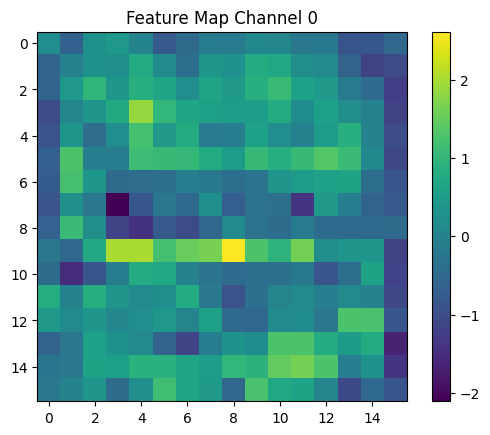

In [152]:
# Visualize a specific channel (e.g., channel 0)
channel = 0  # You can change this to any channel number

plt.imshow(selected_feature_map[0, channel, :, :].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title(f"Feature Map Channel {channel}")
plt.show()

In [153]:
# Find embedding for a specific pixel
def retrieve_embedding(feature_maps, x, y, layers=None):
    """ 
        feature_maps: List of feature maps from the encoder, (x,y): the coordinates of a single pixel, 
        layers: the number of layers to consider (1 = only the last layer, None is all layers).
    """
    embedding = []
    scale = 2

    skip_layers = len(feature_maps) - layers if layers is not None else 0

    # All Transformer blocks (OUTPUTS)
    for idx, features in enumerate(feature_maps):
        if idx < skip_layers or features.shape[0] == 0:
            continue

        # Scale down coordinates
        scaled_x = int(x // (scale**idx))
        scaled_y = int(y // (scale**idx))

        # print(f"Scaled {scale**idx}")
        # print(f"Layer {idx}: {features.shape}")

        # Append the embedding
        pixel_embedding = features[0, :, scaled_x, scaled_y].cpu().numpy()
        embedding.append(pixel_embedding)

    return np.concatenate(embedding) 

In [154]:
embedding = retrieve_embedding(feature_maps, 500, 100, layers=1)
print(f"Dimensionality of the embedding vector: {len(embedding)}")

Dimensionality of the embedding vector: 512


In [155]:
def get_feature_map(image_path, encoder, target_size=(512, 512), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Function to extract the feature maps for a given image path """
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, target_size)
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension
    
    with torch.no_grad():
        feature_maps = encoder(img)

    return feature_maps

In [156]:
def get_predictions(image_path, model, target_size=(512, 512), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Returns the predictions for a given image path """
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, target_size)
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension

    with torch.no_grad():
        output = model(img)
    output = torch.argmax(F.softmax(output, dim=1), dim=1) # softmax: om logits --> probabilities --> klasse index
    
    return output

In [157]:
feature_maps = get_feature_map('dataset/images/0.jpg', encoder)

predictions = get_predictions('dataset/images/0.jpg', model)

print(len(feature_maps))

print(predictions.shape)

6
torch.Size([1, 512, 512])


In [158]:
def create_df():
    name = []
    filenames = os.listdir("dataset/images")
    filenames = sorted(filenames, key=lambda x : int(x.split('.')[0]))
    for filename in filenames:
        name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [159]:
df = create_df()

X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19) # split the data into train and test sets
X_train, X_val = train_test_split(X_train, test_size=0.15, random_state=19) # validate on 15% of the training data

In [160]:
# Read classes json
import json

with open('obj_class_to_machine_color.json', 'r') as f:
    classes = json.load(f)

# List of classes
class_labels = []
for key, value in classes.items():
    class_labels.append(key)

# print(len(class_labels))

important_classes = [
        'Ionic kyma decoration', 
        'Lesbian kyma decoration', 
        'Bead-and-reel (double double)', 
        'Scroll pattern (large)', 
        'Anthemion (large & capital & pulvinus)', 
        'Anthemion (small & soffit & top moulding architrave)', 
        'Acanthus leaves (solo) (capital & frieze & modillion)'
    ]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

### Calculate per image the average embedding for each important class.

In [161]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

encoder = model.encoder

/tmp/ipykernel_6689/1628315217.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



### Calculating the embeddings of all the training images.

In [162]:
""" Here we calculate per important label, the mean embedding of all pixels in the training set that have that label. """
import numpy as np
from collections import defaultdict

global_label_embeddings = defaultdict(list) #  The defaultdict automatically initializes an empty list for a key the first time it is accessed.

th = 0.075 # Threshold for the percentage of pixels with a specific label

# Go through all test images
for img_name in tqdm(X_train, desc="Processing images", colour="green"):
    img_path = f'dataset/images/{img_name}.jpg'
    output_pred = get_predictions(img_path, model).numpy()
    feature_maps = get_feature_map(img_path, encoder)

    unique_labels = [label for label in np.unique(output_pred) if label in labels_import_classes]

    for label in unique_labels:
        # Get X and Y coordinates of all pixels with current important label
        mask = (output_pred[0] == label)
          # EVETUEEL KUNNEN WE HIER NOG EEN EROSIE/DILATIE TOEVOEGEN
        x, y = np.nonzero(mask)

        # Skip if no pixels are found or specific amount of pixels
        percent = len(x) / mask.size
        if percent < th or len(x) == 0:
            continue
                   
        pixel_embeddings = np.array([retrieve_embedding(feature_maps, xi, yi, layers=1) for xi, yi in zip(x, y)]) # Embeddings of all pixels in image with the same label
        mean_embedding = np.mean(pixel_embeddings, axis=0) # Mean embedding of all pixels in image with the same label
        global_label_embeddings[label].append((mean_embedding, img_name))

    # print(f"Processed image: {img_name}")  

In [163]:
# Save the embeddings
# with open('embeddings', 'wb') as f:
#     pickle.dump(global_label_embeddings, f)

In [164]:
# Load the embeddings
import pickle
with open('embeddings_pkl/global_label_embeddings_segformer_last_layer_th_0.075.pkl', 'rb') as f:
    global_label_embeddings = pickle.load(f)

In [165]:
print(len(global_label_embeddings[6][0][0]))

512


### Reading the embeddings

In [166]:
# List of important classes and their corresponding labels
important_classes = [
    'Ionic kyma decoration', 
    'Lesbian kyma decoration', 
    'Bead-and-reel (double double)', 
    'Scroll pattern (large)', 
    'Anthemion (large & capital & pulvinus)', 
    'Anthemion (small & soffit & top moulding architrave)', 
    'Acanthus leaves (solo) (capital & frieze & modillion)'
]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

# Create a mapping of class labels to specific colors (you can change these colors)
color_map = {
    6: 'red',
    1: 'blue',
    15: 'green',
    12: 'purple',
    2: 'orange',
    30: 'yellow',
    29: 'black'
}

# Combine embeddings into a single array and track labels
embeddings = []
labels = []
image_names = []

for label, arrays in global_label_embeddings.items():
    for embedding, img_name in arrays:
        embeddings.append(embedding)  # Add (embedding, image name)
        image_names.append(img_name)  # Add corresponding image name
        labels.append(label)    # Add corresponding (label)

embeddings = np.vstack(embeddings)  # Convert into 2D NumPy array

### Plotting the variance of PCA

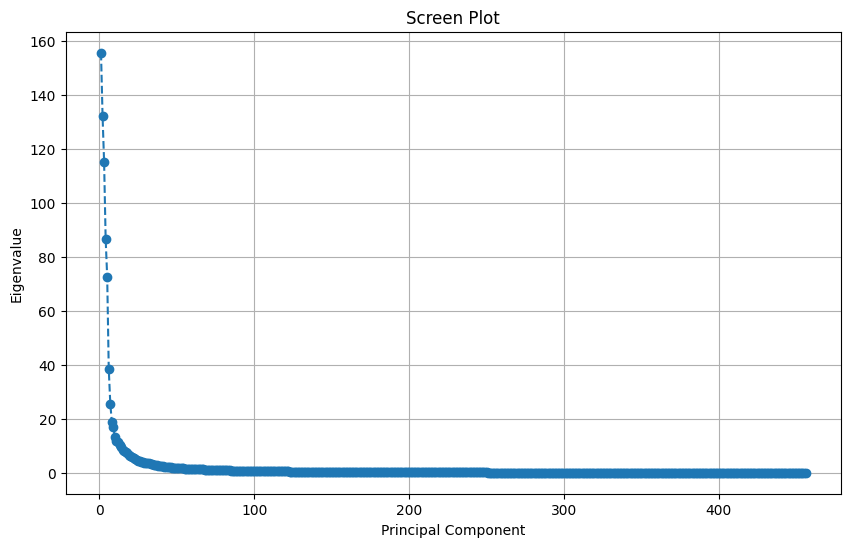

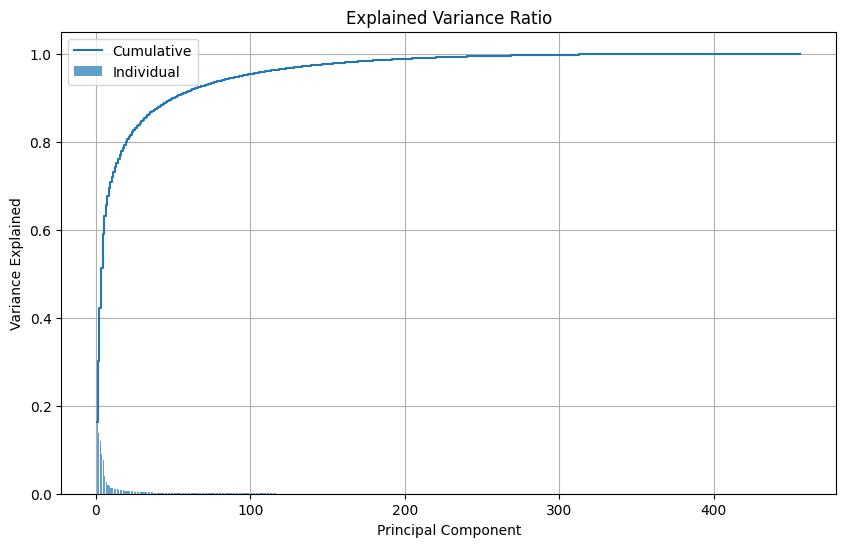

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca.fit(embeddings)

# Eigenvalues (variances of the components)
eigenvalues = pca.explained_variance_

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree Plot (Eigenvalues)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Screen Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Explained Variance Ratio Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend(loc='best')
plt.grid()
plt.show()


In de Explained Variance Ratio grafiek zien we duidelijk dat bij 200 Prinicpal components meer dan 90% van de informatie bewaard blijft. 

### Running PCA and TSNE

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yel

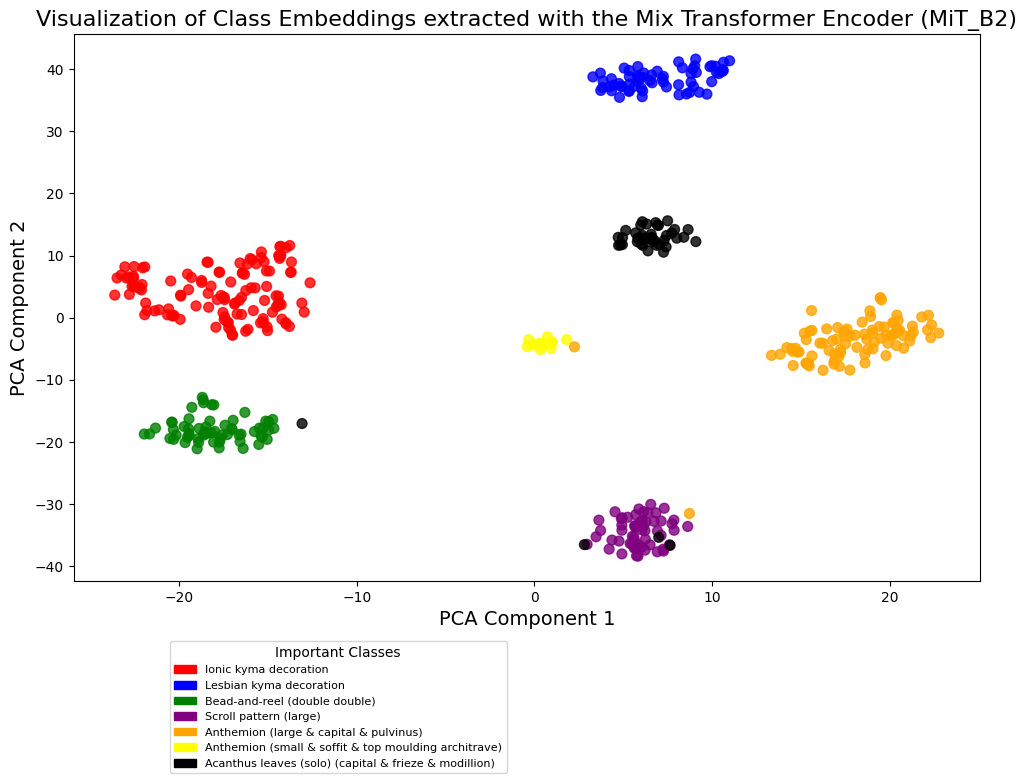

In [168]:
# Initialize TSNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)


# Create color array for each label
colors = [color_map.get(label) for label in labels]  # Default color 'gray' for non-important labels
print(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.8)

# Create a legend   
import matplotlib.patches as mpatches

legend_labels = [mpatches.Patch(color=color_map[label], label=important_classes[i]) for i, label in enumerate(labels_import_classes)]

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.1, -0.1), title="Important Classes", fontsize=8)

plt.title("Visualization of Class Embeddings extracted with the Mix Transformer Encoder (MiT_B2)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)

# Adjust layout to fit the plot and legend
plt.tight_layout()
plt.savefig('class_embeddings_MiT_B2.png')
plt.show()

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



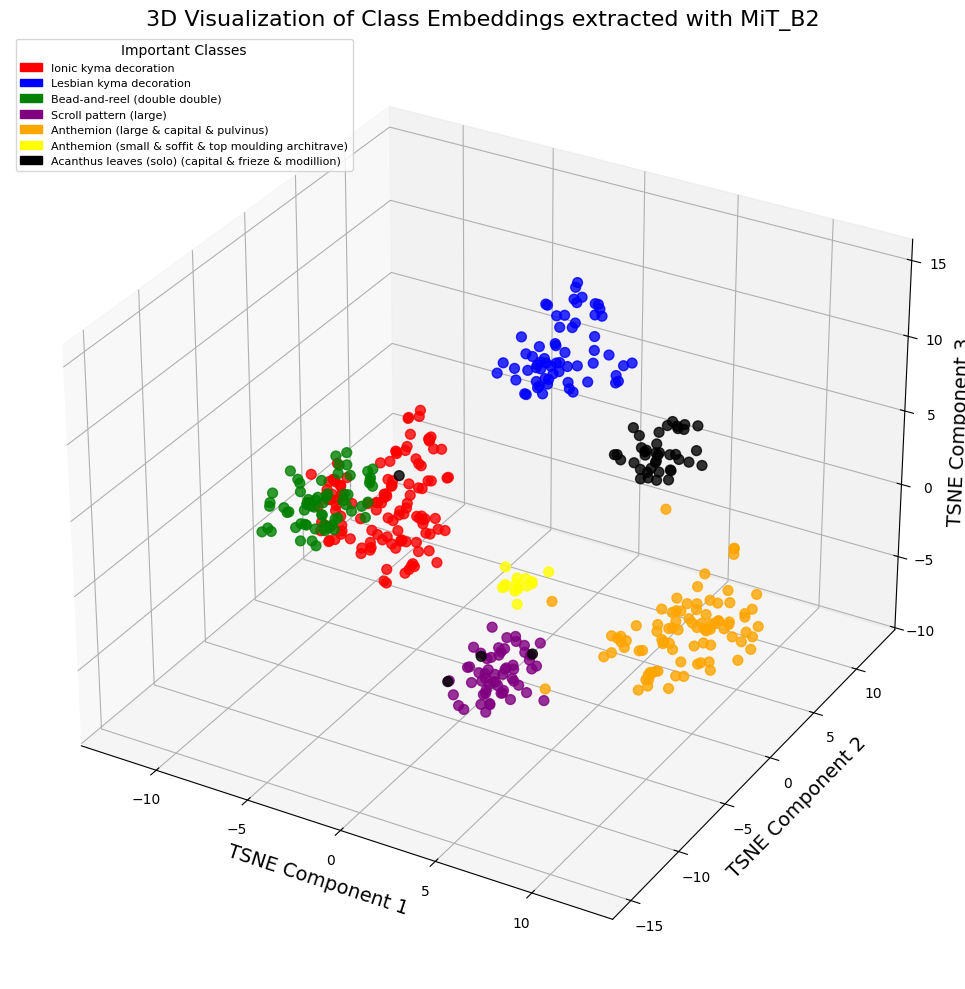

In [169]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches


# Reduce dimensions using PCA (to reduce to 50)
pca = PCA(n_components=200)
embeddings_pca = pca.fit_transform(embeddings)

# Further reduce to 3D with t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)

# Create color array for labels
colors = [color_map.get(label, 'gray') for label in labels]

# Plot in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_embeddings[:, 0], 
    reduced_embeddings[:, 1], 
    reduced_embeddings[:, 2], 
    c=colors, 
    s=50, 
    alpha=0.8
)

# Add legend
legend_labels = [
    mpatches.Patch(color=color_map[label], label=important_classes[i]) 
    for i, label in enumerate(labels_import_classes)
]
ax.legend(handles=legend_labels, loc='upper left', title="Important Classes", fontsize=8)

# Set titles and labels
ax.set_title("3D Visualization of Class Embeddings extracted with MiT_B2", fontsize=16)
ax.set_xlabel("TSNE Component 1", fontsize=14)
ax.set_ylabel("TSNE Component 2", fontsize=14)
ax.set_zlabel("TSNE Component 3", fontsize=14)

plt.tight_layout()
plt.savefig('class_embeddings_MiT_B2_3D.png')
plt.show()


### Interactive plot

In [170]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reduce dimensions using PCA (to reduce to 200)
pca = PCA(n_components=200)
embeddings_pca = pca.fit_transform(embeddings)

# Further reduce to 3D with t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)

# Create a DataFrame for Plotly
df = pd.DataFrame(reduced_embeddings, columns=["TSNE1", "TSNE2", "TSNE3"])

df["label"] = labels
df["image_id"] = image_names
df["image_path"] = df["image_id"].apply(lambda x: f"http://localhost:8000/{x}.jpg")
# print(df.head())

# Map labels to colors
color_map_names = {
    'Ionic kyma decoration': 'red',
    'Lesbian kyma decoration': 'blue',
    'Bead-and-reel (double double)': 'green',
    'Scroll pattern (large)': 'purple',
    'Anthemion (large & capital & pulvinus)': 'orange',
    'Anthemion (small & soffit & top moulding architrave)': 'yellow',
    'Acanthus leaves (solo) (capital & frieze & modillion)': 'black'
}

df["color"] = df["label"].map(color_map_names).fillna("gray") # Default color 'gray' for non-important labels
label_to_class = {label: class_name for label, class_name in zip(labels_import_classes, important_classes)} # Map label to class name
df["class_name"] = df["label"].map(label_to_class).fillna("gray")  # change label to class name

# Create the interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x="TSNE1",
    y="TSNE2",
    z="TSNE3",
    color="class_name",  # Color by the human-readable class names
    color_discrete_map=color_map_names,
    title="Interactive 3D Visualization of Class Embeddings (MiT_B2)",
    hover_data={
        "image_id": True,  # Show image ID on hover
        "label": True,     # Show numeric label on hover
        "class_name": True,  # Show class name on hover
        "image_path": False  # Include image path (optional)
    }
)

fig.update_traces(marker=dict(size=4))

# Customize the axes
fig.update_layout(
    scene=dict(
        xaxis_title="TSNE Component 1",
        yaxis_title="TSNE Component 2",
        zaxis_title="TSNE Component 3",
    ),
    
    legend_title="Class Name"
)

# Display the interactive plot in browser
fig.show(renderer="browser")

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



### Visualizing the decorations in chart

In [171]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def add_thumbnail(ax, x, y, img_path, zoom=0.8, class_label=None):
    """Adds a thumbnail image at the given x, y coordinates."""
    try:
        image = cv.imread('dataset/images/' + img_path + '.jpg')  # Read the image
        image = cv.cvtColor(image, cv.COLOR_BGR2RGBA)
        image = cv.resize(image, (200, 200))  # Resize the image
        
        # Get prediction mask
        # output = cv.imread('predictions/' + img_path + '.png')  # Read the GT mask
        output = get_predictions('dataset/images/' + img_path + '.jpg', model)
        output = output.squeeze(0).numpy()
        
        # resize
        output = cv.resize(output, (200, 200), interpolation=cv.INTER_NEAREST)

        # create mask for the class label
        mask = (output == class_label)

        # Only keep mask, make alpha channel 0 for non-masked pixels
        image[~mask] = [0, 0, 0, 0]

        imagebox = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
        
    except FileNotFoundError:
        print(f"Image {img_path} not found.")

[ERROR glean_core::metrics::ping] Invalid reason code active for ping usage-reporting


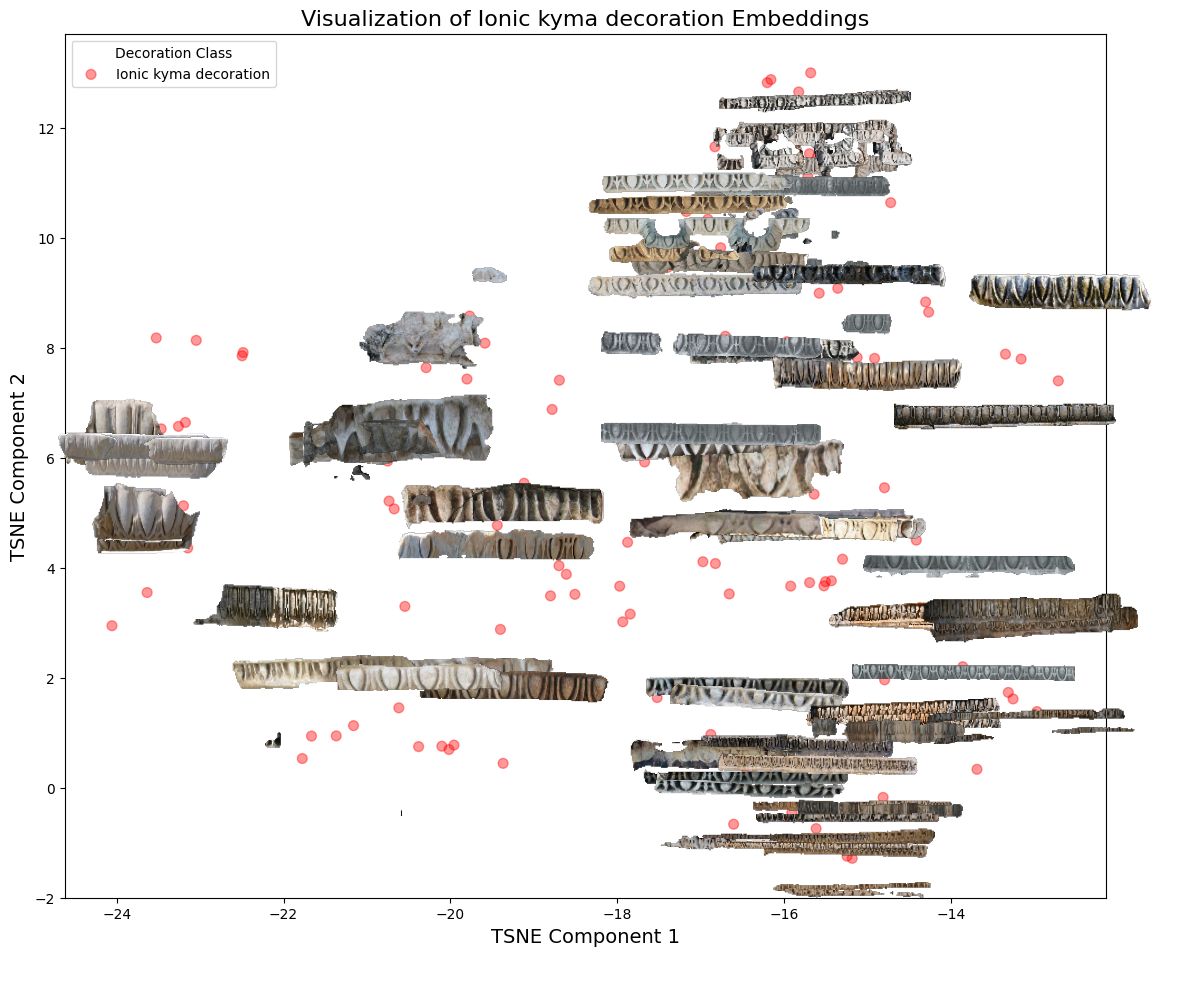

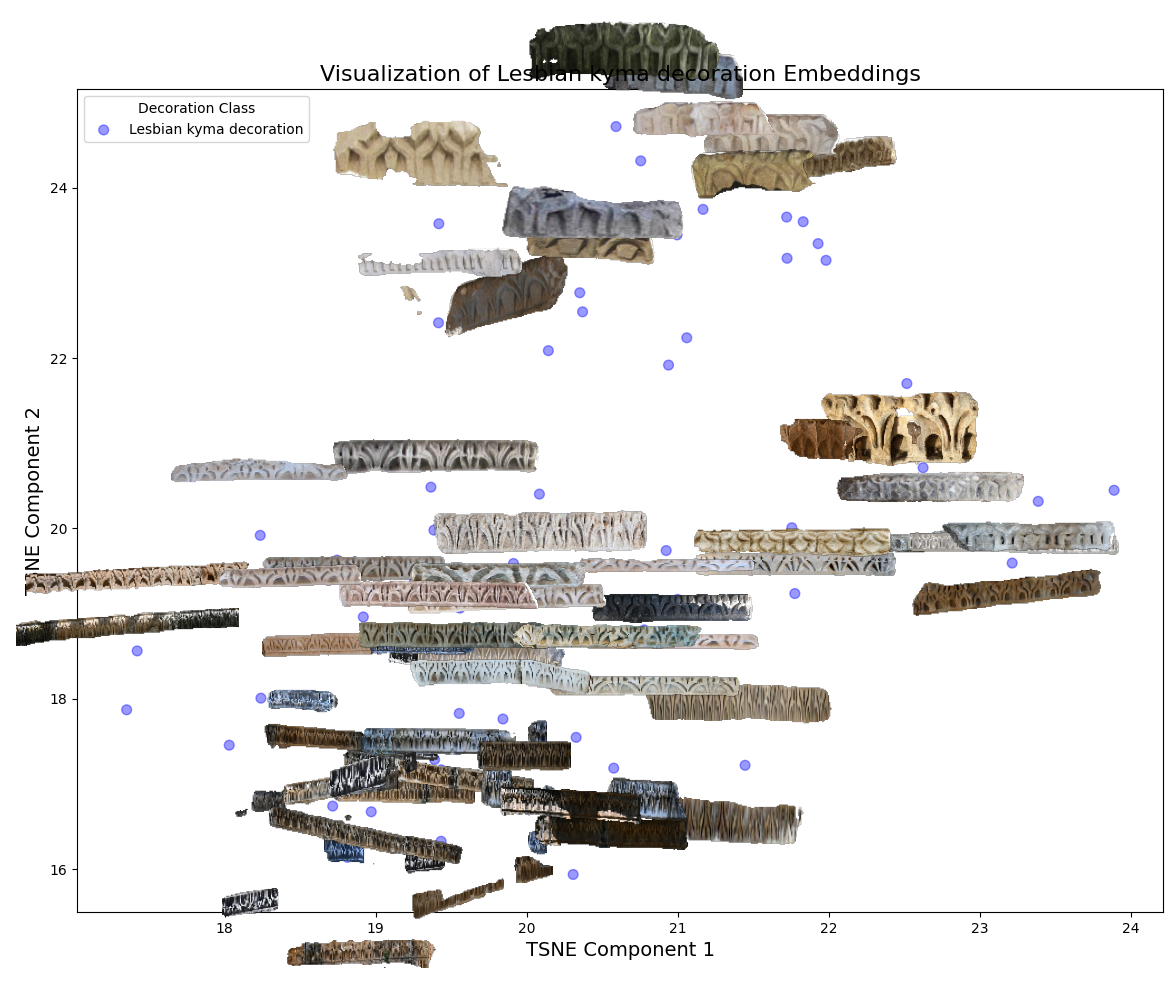

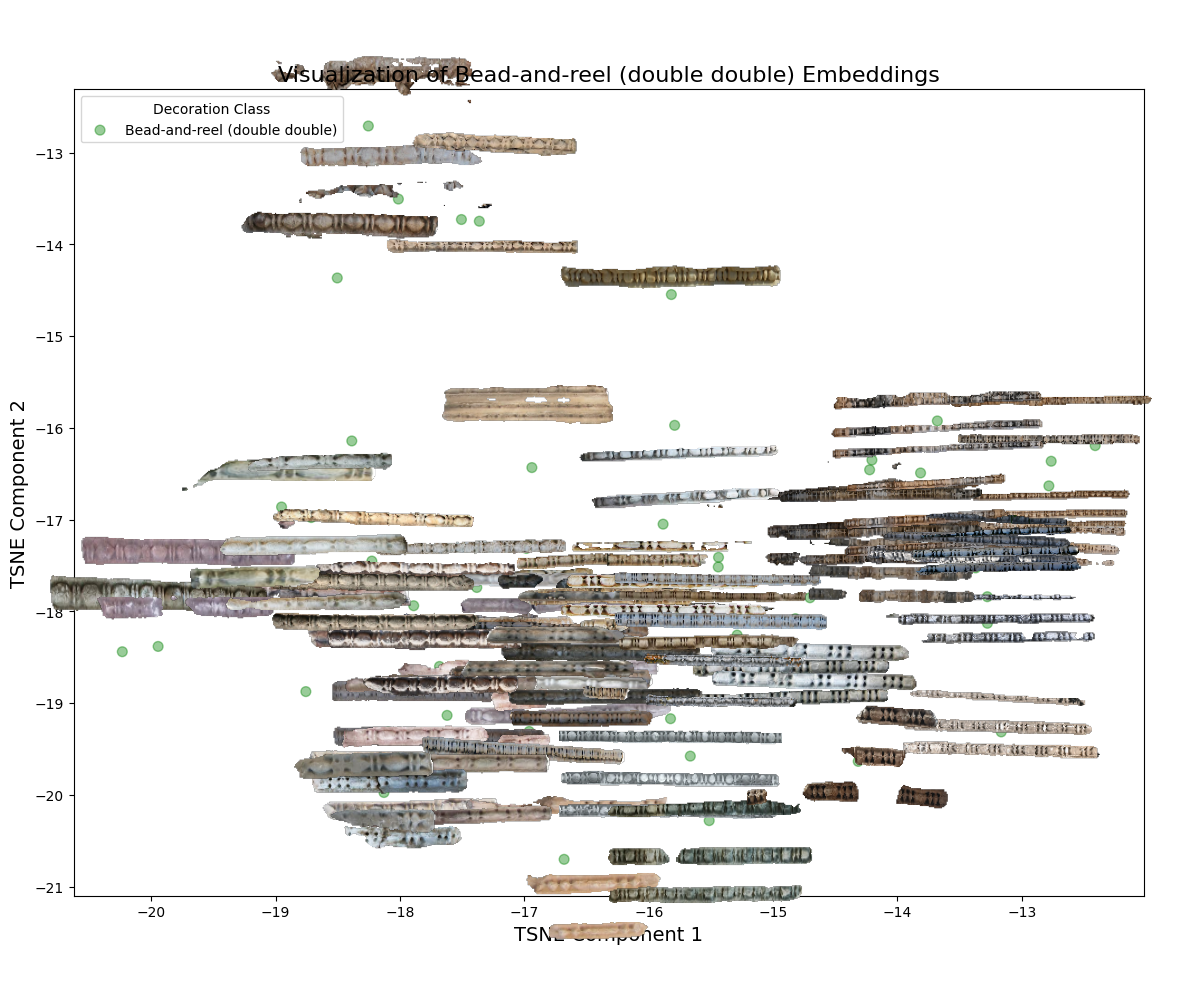

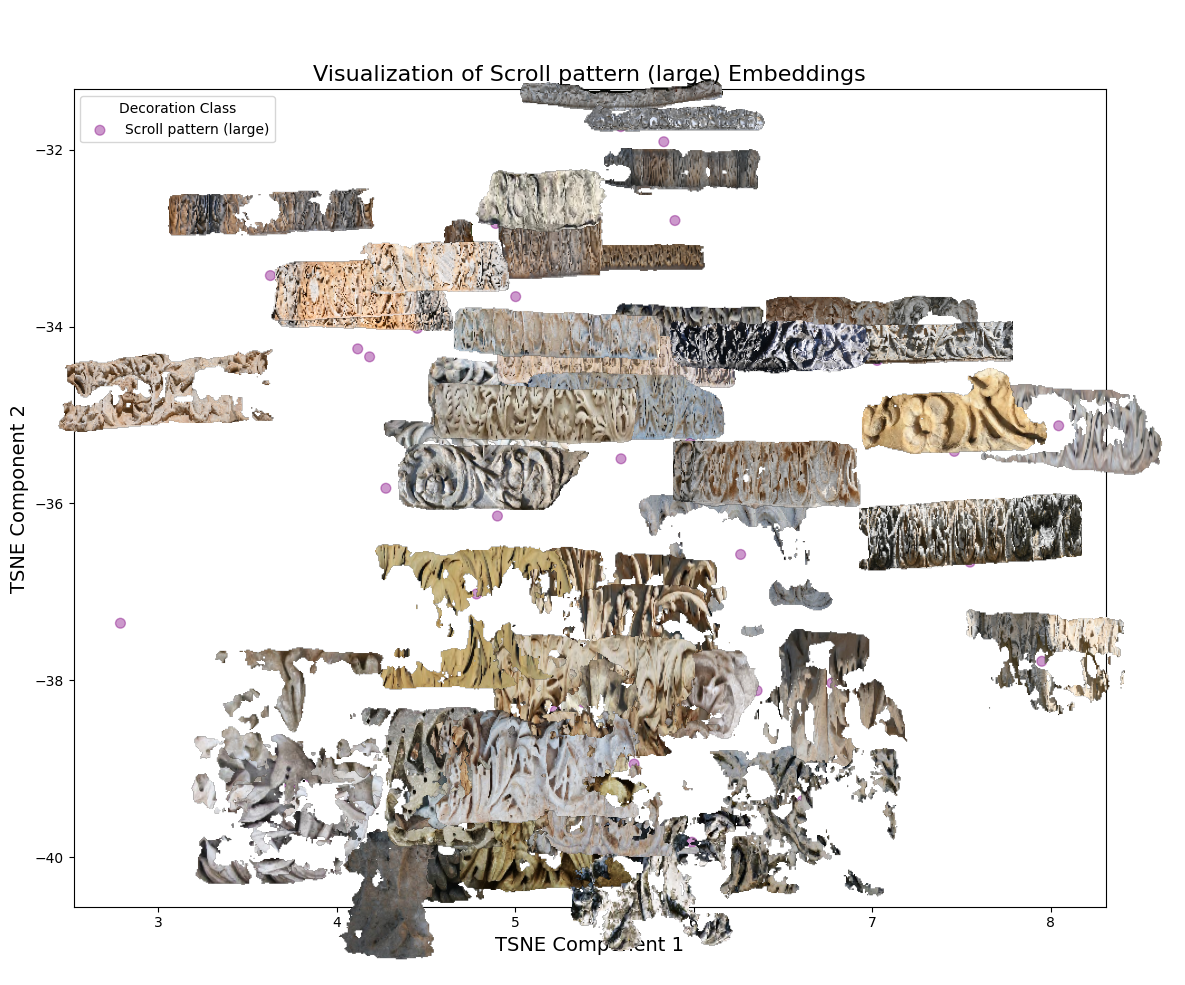

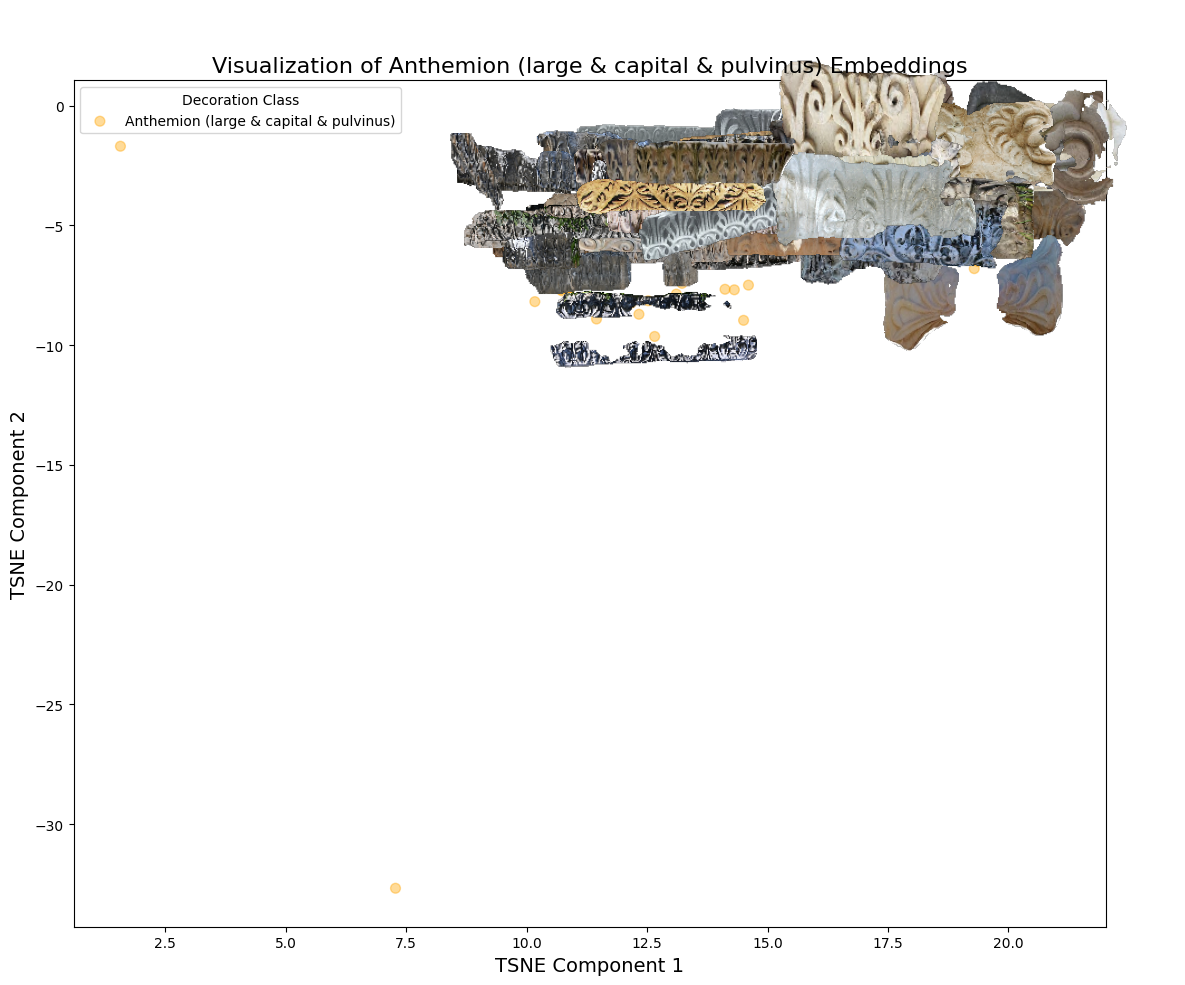

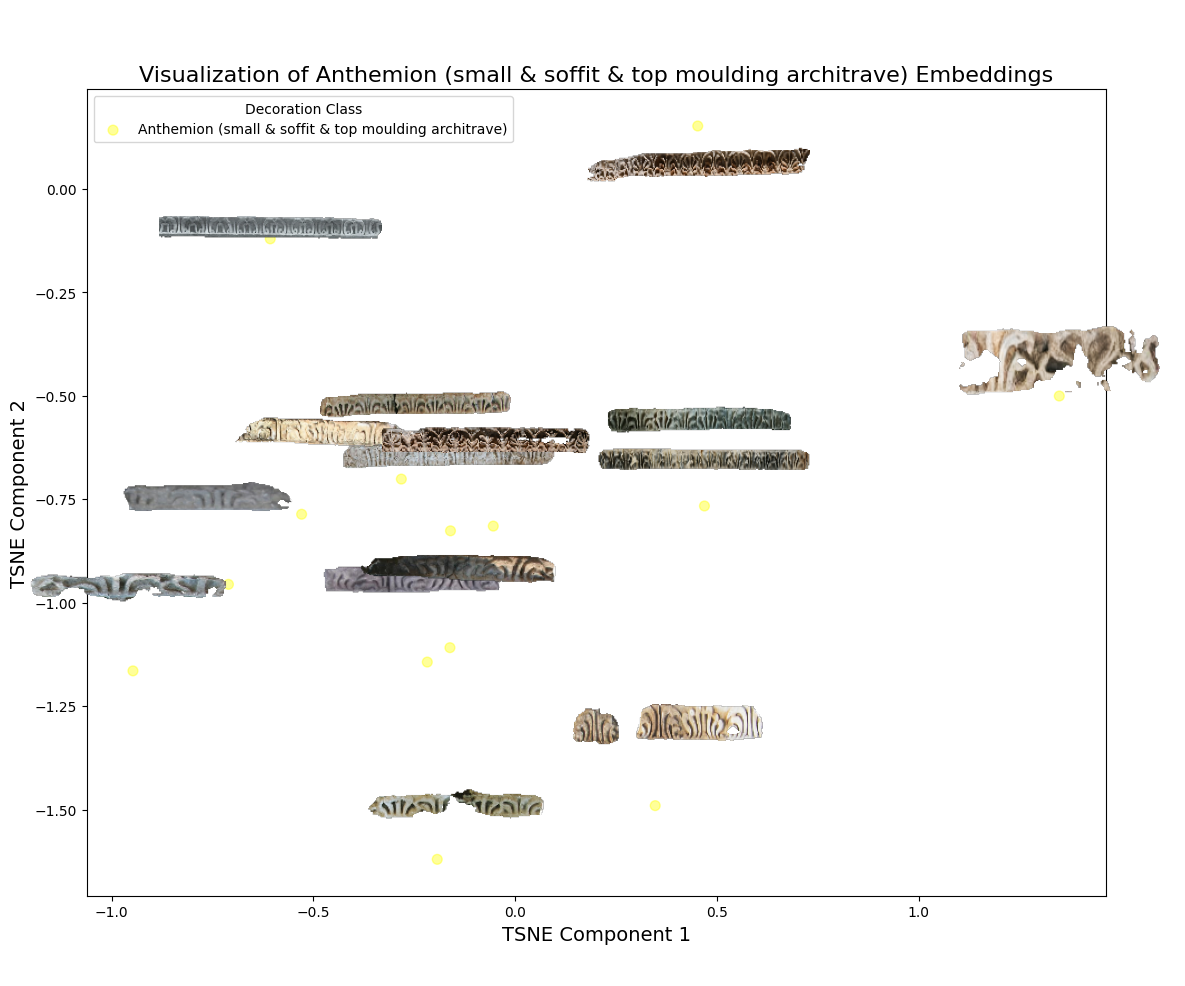

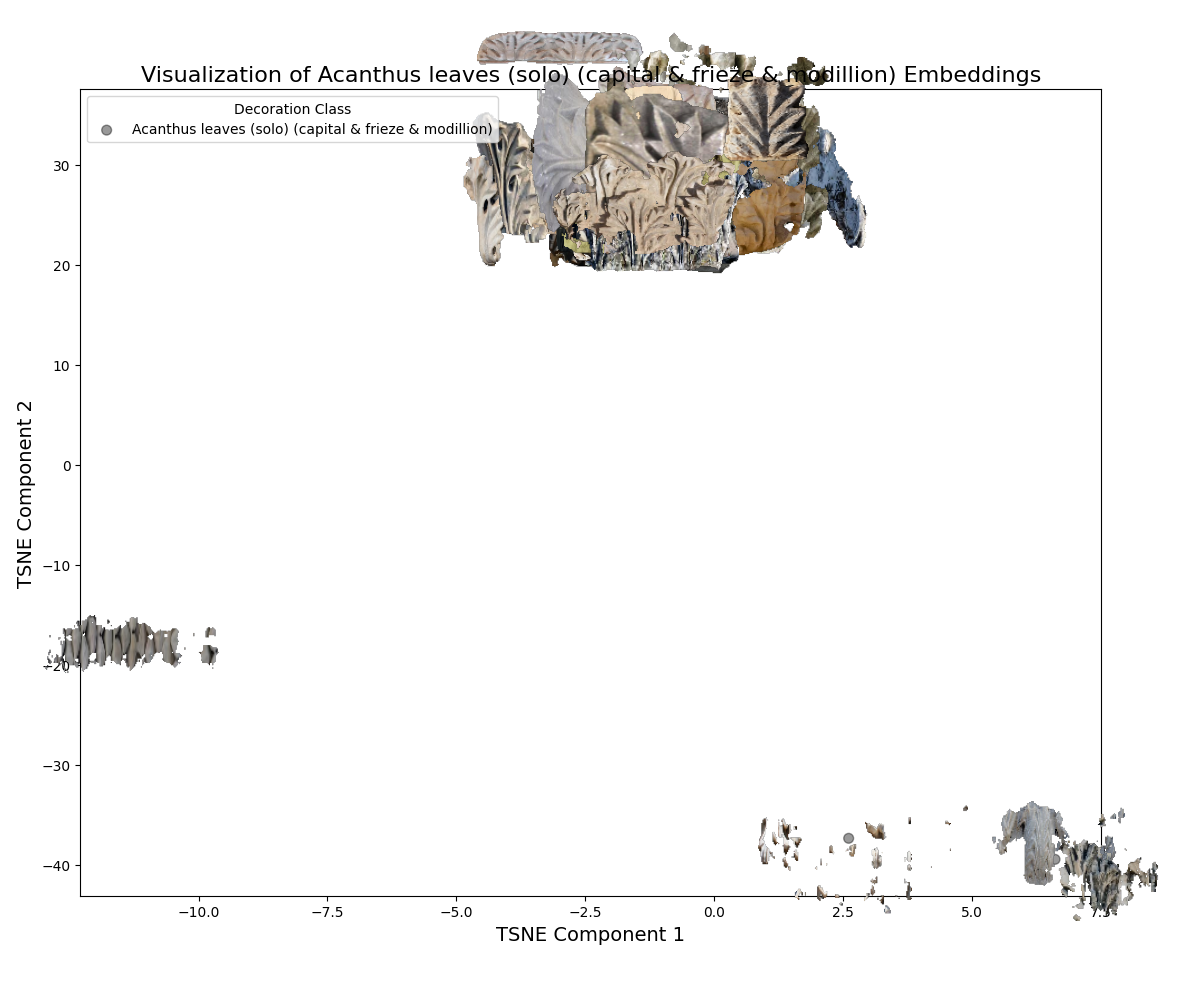

In [172]:
# Initialize TSNE and PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)


for i, label in enumerate(labels_import_classes):
     # Filter embeddings and colors for the current class
    class_indices = [idx for idx, lbl in enumerate(labels) if lbl == label]
    class_images = [image_names[idx] for idx in class_indices]
    class_embeddings = reduced_embeddings[class_indices]
    class_colors = [color_map[label] for _ in class_indices]
    
    # Plot for the current class
    fig, ax = plt.subplots(figsize=(12, 10))

    # Scatter plot for the current class
    plt.scatter(
        class_embeddings[:, 0], 
        class_embeddings[:, 1], 
        c=class_colors, 
        s=50, 
        alpha=0.4, 
        label=important_classes[i]
    )

    # Add thumbnails for the current class
    for (x, y), img_name in zip(class_embeddings[:50], class_images[:50]):
       add_thumbnail(ax, x, y, img_name, zoom=0.8, class_label=label)
    
    # Add legend and titles
    ax.legend(loc='upper left', title="Decoration Class", fontsize=10)
    ax.set_title(f"Visualization of {important_classes[i]} Embeddings", fontsize=16)
    ax.set_xlabel("TSNE Component 1", fontsize=14)
    ax.set_ylabel("TSNE Component 2", fontsize=14)
    
    # Save the plot
    plt.autoscale()
    plt.tight_layout()
    # plt.savefig(f'class_embeddings_{important_classes[i].replace(" ", "_")}.png')
    plt.show()